In [1]:
!pip install pandas


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

In [3]:
# --- ファイルパスの定義（ここをご自身の環境に合わせて変更してください） ---
# 例: Colabの左側のフォルダマークにアップロードした場合のパス
CSV_PATH_BAT = 'stats_bat.csv' 
CSV_PATH_PLAYERS = 'players.csv'
# ------------------------------------------------------------------

print("1. データの読み込みと処理を開始します...")

# ファイルの存在確認
if not os.path.exists(CSV_PATH_BAT) or not os.path.exists(CSV_PATH_PLAYERS):
    print(f"\n【エラー】指定されたパスにファイルが見つかりません。")
    print(f"stats_bat.csv のパス: {os.path.abspath(CSV_PATH_BAT)}")
    print(f"players.csv のパス: {os.path.abspath(CSV_PATH_PLAYERS)}")
    print("パスが正しいか確認し、ファイルを配置してください。")
    exit()

# データの読み込み（文字コード判別対応）
def load_csv_data(filepath):
    # Shift-JIS, CP932, UTF-8 の順でエンコーディングを試行
    for enc in ['shift_jis', 'cp932', 'utf-8']:
        try:
            df = pd.read_csv(filepath, encoding=enc)
            print(f"  -> {os.path.basename(filepath)} を {enc} で読み込み成功。")
            return df
        except UnicodeDecodeError:
            continue
    raise UnicodeDecodeError(f"すべてのエンコーディングで {os.path.basename(filepath)} の読み込みに失敗しました。")

try:
    stats_bat = load_csv_data(CSV_PATH_BAT)
    players = load_csv_data(CSV_PATH_PLAYERS)
except UnicodeDecodeError as e:
    print(f"\n【重大エラー】{e}")
    exit()

# --- データ加工処理 ---

# 1. 選手データからドラフト年度を一意に抽出
player_meta = players[['player_id', 'draft_year']].drop_duplicates(subset=['player_id'])

# ドラフト年度を数値化（エラーはNaNにする）
player_meta['draft_year'] = pd.to_numeric(player_meta['draft_year'], errors='coerce')
player_meta = player_meta.dropna(subset=['draft_year'])

# 2. 成績データと結合
# 'stats_bat.csv'に成績年度を示すカラム名が 'season_year' であることを前提としています。
if 'season_year' not in stats_bat.columns:
    print("\n【エラー】'stats_bat.csv'に成績年度を示す 'season_year' カラムが見つかりません。")
    print(f"見つかったカラム: {stats_bat.columns.tolist()}")
    exit()
    
df = pd.merge(stats_bat, player_meta, on='player_id', how='inner')

# 3. プロ年数の計算 (成績年度 - ドラフト年)
df['pro_year'] = df['season_year'] - df['draft_year']

# 4. フィルタリング

# 条件A: プロ5年目以上
df_active = df[df['pro_year'] >= 5]

# 条件B: 規定打席444打席以上
df_active = df_active[df_active['pa'] >= 444]

# 条件C: 打率.250以上
# 打数が0でないデータのみを対象とし、打率を計算
df_active = df_active[df_active['ab'] > 0].copy()
df_active['avg'] = df_active['h'] / df_active['ab']
df_active = df_active[df_active['avg'] >= 0.250]

# 5. 出力用データの整形
output_columns = [
    'player_id', 'season_year', 'player_name', 'team_name',
    'pro_year', 'avg', 'g', 'pa', 'ab', 'h', 'hr', 'rbi', 'so', 'bb', 'sb'
]

# 該当する列が存在するか確認してから抽出（存在しない列はスキップ）
existing_cols = [col for col in output_columns if col in df_active.columns]
df_clean = df_active[existing_cols].copy()

# 打率を3桁で丸める
if 'avg' in df_clean.columns:
    df_clean['avg'] = df_clean['avg'].round(3)

# 並び替え（プロ年数 降順 -> 打率 降順）
df_clean = df_clean.sort_values(by=['pro_year', 'avg'], ascending=[False, False])

# CSV保存
output_filename = 'pro_baseball_analysis_data.csv'
df_clean.to_csv(output_filename, index=False, encoding='utf-8-sig')

print(f"\n2. 処理完了。'{output_filename}' に結果を保存しました。")
print(f"抽出件数: {len(df_clean)} 件")

# --- 分析: それを達成したのはプロ何年目が多いか？ ---
print("\n-----------------------------------------------------")
print("⚾ プロ何年目での達成が多いか（件数集計）")
if len(df_clean) > 0:
    year_counts = df_clean['pro_year'].value_counts().sort_index()
    print(year_counts)
else:
    print("抽出件数が0のため集計できませんでした。")

1. データの読み込みと処理を開始します...
  -> stats_bat.csv を cp932 で読み込み成功。
  -> players.csv を cp932 で読み込み成功。

2. 処理完了。'pro_baseball_analysis_data.csv' に結果を保存しました。
抽出件数: 139 件

-----------------------------------------------------
⚾ プロ何年目での達成が多いか（件数集計）
pro_year
5.0     23
6.0     19
7.0     18
8.0     12
9.0      9
10.0    15
11.0     9
12.0     9
13.0     8
14.0     6
15.0     4
16.0     2
17.0     2
18.0     1
20.0     2
Name: count, dtype: int64


1. データの読み込みと処理を開始します...
  -> stats_bat.csv を cp932 で読み込み成功。
  -> players.csv を cp932 で読み込み成功。

2. 処理完了。'pro_baseball_analysis_data.csv' に結果を保存しました。
抽出件数: 139 件

-----------------------------------------------------
⚾ プロ何年目での達成が多いか（件数集計）
pro_year
5.0     23
6.0     19
7.0     18
8.0     12
9.0      9
10.0    15
11.0     9
12.0     9
13.0     8
14.0     6
15.0     4
16.0     2
17.0     2
18.0     1
20.0     2
Name: count, dtype: int64

-----------------------------------------------------
🏆 ドラフト順位 (draft_round) 別 活躍事例の件数集計
（プロ5年目以降、規定打席達成、打率.250以上の件数）
draft_round
10位        2
1位        39
2位        20
2巡目        1
3位        20
4位        17
4巡目        2
5位        14
6位         7
7位         4
9位         5
（育）2位      1
（育）5位      1
（高）1巡目     2
（高）3巡目     4
Name: count, dtype: int64


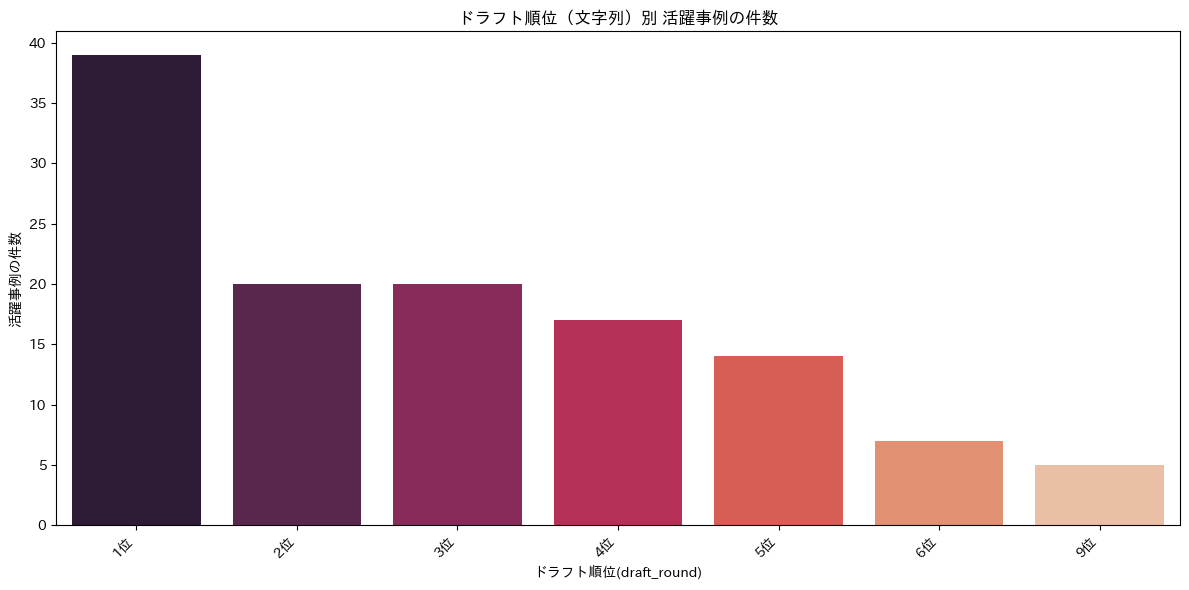

In [4]:
# 日本語表示の設定 (Colab/Jupyter環境向け)
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.sans-serif'] = ['IPAexGothic', 'Noto Sans CJK JP', 'Meiryo', 'TakaoGothic']
plt.rcParams['axes.unicode_minus'] = False 

# --- ファイルパスの定義（ここをご自身の環境に合わせて変更してください） ---
CSV_PATH_BAT = 'stats_bat.csv' 
CSV_PATH_PLAYERS = 'players.csv'
# ------------------------------------------------------------------

print("1. データの読み込みと処理を開始します...")

# ファイルの存在確認
if not os.path.exists(CSV_PATH_BAT) or not os.path.exists(CSV_PATH_PLAYERS):
    print(f"\n【エラー】指定されたパスにファイルが見つかりません。")
    print("パスが正しいか確認し、ファイルを配置してください。")
    exit()

# データの読み込み（文字コード判別対応）
def load_csv_data(filepath):
    for enc in ['shift_jis', 'cp932', 'utf-8']:
        try:
            df = pd.read_csv(filepath, encoding=enc)
            print(f"  -> {os.path.basename(filepath)} を {enc} で読み込み成功。")
            return df
        except UnicodeDecodeError:
            continue
    raise UnicodeDecodeError(f"すべてのエンコーディングで {os.path.basename(filepath)} の読み込みに失敗しました。")

try:
    stats_bat = load_csv_data(CSV_PATH_BAT)
    players = load_csv_data(CSV_PATH_PLAYERS)
except UnicodeDecodeError as e:
    print(f"\n【重大エラー】{e}")
    exit()

# --- データ加工処理 ---

# 1. 選手データからドラフト年度と順位を一意に抽出 (★修正・追加点)
# draft_roundをそのまま文字列として結合に使用
player_meta = players[['player_id', 'draft_year', 'draft_round']].drop_duplicates(subset=['player_id'])

# ドラフト年度を数値化（エラーはNaNにする）
player_meta['draft_year'] = pd.to_numeric(player_meta['draft_year'], errors='coerce')
player_meta = player_meta.dropna(subset=['draft_year'])

# 2. 成績データと結合
if 'season_year' not in stats_bat.columns:
    print("\n【エラー】'stats_bat.csv'に成績年度を示す 'season_year' カラムが見つかりません。")
    print(f"見つかったカラム: {stats_bat.columns.tolist()}")
    exit()
    
# ドラフト順位情報も一緒に結合する
df = pd.merge(stats_bat, player_meta, on='player_id', how='inner')

# 3. プロ年数の計算 (成績年度 - ドラフト年)
df['pro_year'] = df['season_year'] - df['draft_year']

# 4. フィルタリング (★元の処理と変更なし)
# 条件A: プロ5年目以上
df_active = df[df['pro_year'] >= 5]
# 条件B: 規定打席444打席以上
df_active = df_active[df_active['pa'] >= 444]
# 条件C: 打率.250以上
df_active = df_active[df_active['ab'] > 0].copy()
df_active['avg'] = df_active['h'] / df_active['ab']
df_active = df_active[df_active['avg'] >= 0.250]

# 5. 出力用データの整形 (★draft_roundを追加)
output_columns = [
    'player_id', 'season_year', 'player_name', 'team_name',
    'pro_year', 'avg', 'g', 'pa', 'ab', 'h', 'hr', 'rbi', 'so', 'bb', 'sb', 
    'draft_round' # draft_roundを追加
]

existing_cols = [col for col in output_columns if col in df_active.columns]
df_clean = df_active[existing_cols].copy()

if 'avg' in df_clean.columns:
    df_clean['avg'] = df_clean['avg'].round(3)

df_clean = df_clean.sort_values(by=['pro_year', 'avg'], ascending=[False, False])

# CSV保存
output_filename = 'pro_baseball_analysis_data.csv'
df_clean.to_csv(output_filename, index=False, encoding='utf-8-sig')

print(f"\n2. 処理完了。'{output_filename}' に結果を保存しました。")
print(f"抽出件数: {len(df_clean)} 件")

# --- 分析: 活躍事例の件数集計（プロ年数別） ---
print("\n-----------------------------------------------------")
print("⚾ プロ何年目での達成が多いか（件数集計）")
if len(df_clean) > 0:
    year_counts = df_clean['pro_year'].value_counts().sort_index()
    print(year_counts)
else:
    print("抽出件数が0のため集計できませんでした。")


# --- 新規追加分析: ドラフト順位 (draft_round) 別 活躍事例の件数集計 ---
print("\n-----------------------------------------------------")
print("🏆 ドラフト順位 (draft_round) 別 活躍事例の件数集計")

if 'draft_round' in df_clean.columns and len(df_clean) > 0:
    
    # draft_round の文字列値ごとに件数をカウント
    round_counts = df_clean['draft_round'].value_counts()
    
    # 順位 (文字列) を数値部分でソートするために変換（例: '1' < '10' < '2' となるのを防ぐ）
    # 数値順位 ('1', '2', ...) とその他 ('育1', '外'など) を分離
    
    # 数値順位の抽出
    numerical_ranks = pd.to_numeric(round_counts.index, errors='coerce').dropna().astype(int)
    numerical_counts = round_counts[numerical_ranks.astype(str)].sort_index()

    # 非数値順位の抽出（育成、外など）
    non_numerical_ranks = round_counts[round_counts.index.difference(numerical_ranks.astype(str))]
    
    # 全ての順位を結合（数値順位 + その他）
    # 数値順位の表示が優先されるようソート
    sorted_counts = pd.concat([numerical_counts, non_numerical_ranks]).sort_index()
    
    print("（プロ5年目以降、規定打席達成、打率.250以上の件数）")
    print(sorted_counts)
    
    # --- グラフ描画 ---
    plt.figure(figsize=(12, 6))
    
    # グラフを見やすくするため、件数が5件以上の順位に限定して表示 (調整可能)
    top_rounds = sorted_counts[sorted_counts >= 5]
    
    #sns.barplot(x=top_rounds.index, y=top_rounds.values, palette="rocket")
    sns.barplot(x=top_rounds.index, y=top_rounds.values, hue=top_rounds.index, palette="rocket", legend=False)
    plt.title('ドラフト順位（文字列）別 活躍事例の件数')
    plt.xlabel('ドラフト順位(draft_round)')
    plt.ylabel('活躍事例の件数')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    

else:
    print("抽出件数が0件、または 'draft_round' カラムがないため、ドラフト順位別分析はスキップされました。")

1. データの読み込みと処理を開始します...
  -> stats_bat.csv を cp932 で読み込み成功。
  -> players.csv を cp932 で読み込み成功。

2. 処理完了。'pro_baseball_analysis_data_first_break.csv' に結果を保存しました。
抽出件数: 76 件

-----------------------------------------------------
⚾ 初回ブレイク事例が多かったプロ年目（件数集計）
pro_year
5.0     23
6.0     10
7.0     10
8.0      3
9.0      4
10.0    10
11.0     3
12.0     3
13.0     4
14.0     1
15.0     1
16.0     1
18.0     1
20.0     2
Name: count, dtype: int64

-----------------------------------------------------
🏆 ドラフト順位 (draft_round) 別 初回ブレイク事例の件数集計
（プロ5年目以降、規定打席達成、打率.250以上の初回達成事例の件数）
draft_round
10位        1
1位        18
2位        13
2巡目        1
3位        12
4位         8
4巡目        2
5位         9
6位         3
7位         3
9位         1
（育）2位      1
（育）5位      1
（高）1巡目     1
（高）3巡目     2
Name: count, dtype: int64


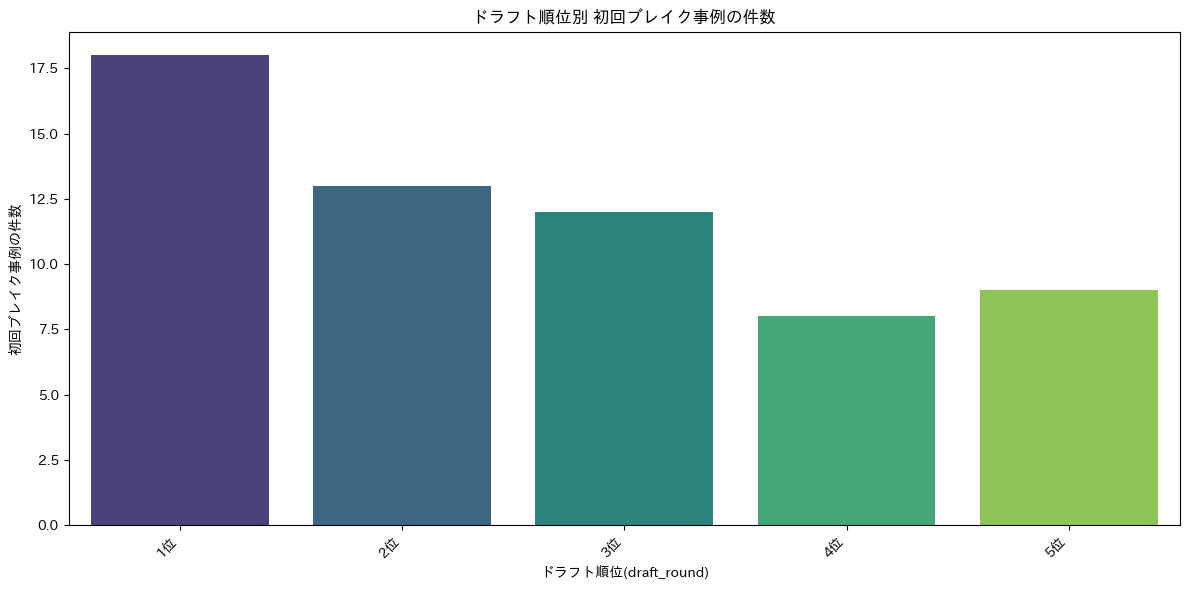

In [5]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns # グラフ描画用

# 日本語表示の設定 (フォントエラー対策済み)
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['axes.unicode_minus'] = False 

# --- ファイルパスの定義（ここをご自身の環境に合わせて変更してください） ---
CSV_PATH_BAT = 'stats_bat.csv' 
CSV_PATH_PLAYERS = 'players.csv'
# ------------------------------------------------------------------

print("1. データの読み込みと処理を開始します...")

# ファイルの存在確認
if not os.path.exists(CSV_PATH_BAT) or not os.path.exists(CSV_PATH_PLAYERS):
    print(f"\n【エラー】指定されたパスにファイルが見つかりません。")
    print("パスが正しいか確認し、ファイルを配置してください。")
    exit()

# データの読み込み（文字コード判別対応）
def load_csv_data(filepath):
    for enc in ['shift_jis', 'cp932', 'utf-8']:
        try:
            df = pd.read_csv(filepath, encoding=enc)
            print(f"  -> {os.path.basename(filepath)} を {enc} で読み込み成功。")
            return df
        except UnicodeDecodeError:
            continue
    raise UnicodeDecodeError(f"すべてのエンコーディングで {os.path.basename(filepath)} の読み込みに失敗しました。")

try:
    stats_bat = load_csv_data(CSV_PATH_BAT)
    players = load_csv_data(CSV_PATH_PLAYERS)
except UnicodeDecodeError as e:
    print(f"\n【重大エラー】{e}")
    exit()

# --- データ加工処理 ---

# 1. 選手データからドラフト年度と順位を一意に抽出
player_meta = players[['player_id', 'draft_year', 'draft_round']].drop_duplicates(subset=['player_id'])
player_meta['draft_year'] = pd.to_numeric(player_meta['draft_year'], errors='coerce')
player_meta = player_meta.dropna(subset=['draft_year'])

# 2. 成績データと結合
if 'season_year' not in stats_bat.columns:
    print("\n【エラー】'stats_bat.csv'に成績年度を示す 'season_year' カラムが見つかりません。")
    print(f"見つかったカラム: {stats_bat.columns.tolist()}")
    exit()
    
df = pd.merge(stats_bat, player_meta, on='player_id', how='inner')

# 3. プロ年数の計算 (成績年度 - ドラフト年)
df['pro_year'] = df['season_year'] - df['draft_year']

# 4. フィルタリング (元の条件: 活躍事例)
# 条件A: プロ5年目以上, 条件B: 規定打席444打席以上, 条件C: 打率.250以上
df_active = df[df['pro_year'] >= 5]
df_active = df_active[df_active['pa'] >= 444]
df_active = df_active[df_active['ab'] > 0].copy()
df_active['avg'] = df_active['h'] / df_active['ab']
df_active = df_active[df_active['avg'] >= 0.250]


# --- ★修正・追加点: 初回達成年のみを抽出する処理 ---
if len(df_active) > 0:
    # 選手IDごとに、活躍条件を達成した最初の年 (min_season_year) を特定
    first_success_year = df_active.groupby('player_id')['season_year'].min().reset_index()
    first_success_year.rename(columns={'season_year': 'first_success_year'}, inplace=True)
    
    # 元の df_active に初回達成年を結合
    df_active_merged = pd.merge(df_active, first_success_year, on='player_id', how='left')
    
    # 初回達成年とシーズン年が一致する行のみを抽出 (これが「初回ブレイク事例」のデータ)
    df_first_break = df_active_merged[
        df_active_merged['season_year'] == df_active_merged['first_success_year']
    ].copy()
    
    df_clean = df_first_break.copy()
else:
    # 活躍事例自体が0件の場合
    df_clean = pd.DataFrame()
    print("【注意】活躍事例が0件のため、分析対象がありません。")


# --- 5. 出力用データの整形 ---

if len(df_clean) > 0:
    output_columns = [
        'player_id', 'season_year', 'player_name', 'team_name',
        'pro_year', 'avg', 'g', 'pa', 'ab', 'h', 'hr', 'rbi', 'so', 'bb', 'sb', 
        'draft_round'
    ]

    existing_cols = [col for col in output_columns if col in df_clean.columns]
    df_clean = df_clean[existing_cols].copy()

    if 'avg' in df_clean.columns:
        df_clean['avg'] = df_clean['avg'].round(3)

    # 初回達成年であるため、プロ年数、打率でソート
    df_clean = df_clean.sort_values(by=['pro_year', 'avg'], ascending=[False, False])

    # CSV保存
    output_filename = 'pro_baseball_analysis_data_first_break.csv'
    df_clean.to_csv(output_filename, index=False, encoding='utf-8-sig')

    print(f"\n2. 処理完了。'{output_filename}' に結果を保存しました。")
    print(f"抽出件数: {len(df_clean)} 件")

    # --- 分析: 初回ブレイク事例の件数集計（プロ年数別） ---
    print("\n-----------------------------------------------------")
    print("⚾ 初回ブレイク事例が多かったプロ年目（件数集計）")
    year_counts = df_clean['pro_year'].value_counts().sort_index()
    print(year_counts)

    # --- ドラフト順位 (draft_round) 別 初回ブレイク事例の件数集計 ---
    print("\n-----------------------------------------------------")
    print("🏆 ドラフト順位 (draft_round) 別 初回ブレイク事例の件数集計")

    if 'draft_round' in df_clean.columns:
        
        # draft_round の文字列値ごとに件数をカウント
        round_counts = df_clean['draft_round'].value_counts()
        
        # 順位 (文字列) を数値部分でソートするために処理
        numerical_ranks = pd.to_numeric(round_counts.index, errors='coerce').dropna().astype(int)
        numerical_counts = round_counts[numerical_ranks.astype(str)].sort_index()
        non_numerical_ranks = round_counts[round_counts.index.difference(numerical_ranks.astype(str))]
        
        sorted_counts = pd.concat([numerical_counts, non_numerical_ranks]).sort_index()
        
        print("（プロ5年目以降、規定打席達成、打率.250以上の初回達成事例の件数）")
        print(sorted_counts)
        
        # --- グラフ描画 ---
        plt.figure(figsize=(12, 6))
        
        # グラフを見やすくするため、件数が5件以上の順位に限定して表示
        top_rounds = sorted_counts[sorted_counts >= 5]
        
        sns.barplot(x=top_rounds.index, y=top_rounds.values, hue=top_rounds.index, palette="viridis", legend=False)
        plt.title('ドラフト順位別 初回ブレイク事例の件数')
        plt.xlabel('ドラフト順位(draft_round)')
        plt.ylabel('初回ブレイク事例の件数')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        

else:
    print("\n【最終結果】初回ブレイク事例が0件のため、分析はスキップされました。")

1. データの読み込みと処理を開始します...
  -> stats_bat.csv を cp932 で読み込み成功。
  -> players.csv を cp932 で読み込み成功。

2. 処理完了。初回ブレイク事例件数: 76 件

-----------------------------------------------------
📊 ドラフト順位(数値)別 × 初回ブレイク達成年数 の件数表

【注意】初回ブレイク事例の中に、数値順位を持つ選手がいなかったため、ヒートマップはスキップされました。（全て「育〇」や「外」の選手である可能性があります。）

-----------------------------------------------------
⚾ 全ての初回ブレイク事例が多かったプロ年目（件数集計）
pro_year
5.0     23
6.0     10
7.0     10
8.0      3
9.0      4
10.0    10
11.0     3
12.0     3
13.0     4
14.0     1
15.0     1
16.0     1
18.0     1
20.0     2
Name: count, dtype: int64


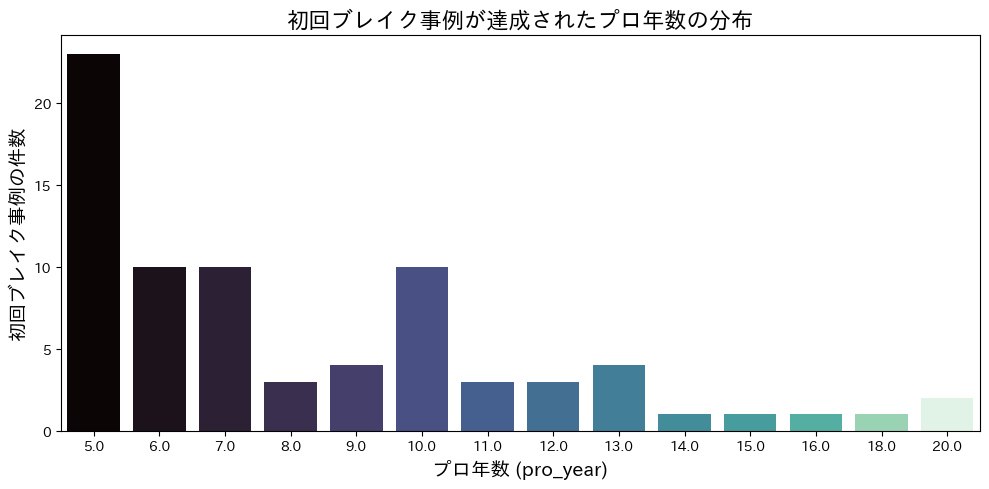

In [7]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns # グラフ描画用
import numpy as np # np.nanmean のために使用

# 日本語表示の設定 (フォントエラー対策済み)
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['axes.unicode_minus'] = False 

# --- ファイルパスの定義（ここをご自身の環境に合わせて変更してください） ---
CSV_PATH_BAT = 'stats_bat.csv' 
CSV_PATH_PLAYERS = 'players.csv'
# ------------------------------------------------------------------

print("1. データの読み込みと処理を開始します...")

# ファイルの存在確認
if not os.path.exists(CSV_PATH_BAT) or not os.path.exists(CSV_PATH_PLAYERS):
    print(f"\n【エラー】指定されたパスにファイルが見つかりません。")
    exit()

# データの読み込み（文字コード判別対応）
def load_csv_data(filepath):
    for enc in ['shift_jis', 'cp932', 'utf-8']:
        try:
            df = pd.read_csv(filepath, encoding=enc)
            print(f"  -> {os.path.basename(filepath)} を {enc} で読み込み成功。")
            return df
        except UnicodeDecodeError:
            continue
    raise UnicodeDecodeError(f"すべてのエンコーディングで {os.path.basename(filepath)} の読み込みに失敗しました。")

try:
    stats_bat = load_csv_data(CSV_PATH_BAT)
    players = load_csv_data(CSV_PATH_PLAYERS)
except UnicodeDecodeError as e:
    print(f"\n【重大エラー】{e}")
    exit()

# --- データ加工処理 (初回ブレイク事例の抽出) ---

# 1. 選手データからドラフト年度と順位を一意に抽出
player_meta = players[['player_id', 'draft_year', 'draft_round']].drop_duplicates(subset=['player_id'])
player_meta['draft_year'] = pd.to_numeric(player_meta['draft_year'], errors='coerce')
player_meta = player_meta.dropna(subset=['draft_year'])

# 2. 成績データと結合
if 'season_year' not in stats_bat.columns:
    print("\n【エラー】'stats_bat.csv'に成績年度を示す 'season_year' カラムが見つかりません。")
    exit()
    
df = pd.merge(stats_bat, player_meta, on='player_id', how='inner')

# 3. プロ年数の計算 (成績年度 - ドラフト年)
df['pro_year'] = df['season_year'] - df['draft_year']

# 4. フィルタリング (活躍事例: プロ5年目以上, 規定打席, 打率.250以上)
df_active = df[df['pro_year'] >= 5]
df_active = df_active[df_active['pa'] >= 444]
df_active = df_active[df_active['ab'] > 0].copy()
df_active['avg'] = df_active['h'] / df_active['ab']
df_active = df_active[df_active['avg'] >= 0.250]

# 初回達成年のみを抽出
if len(df_active) > 0:
    first_success_year = df_active.groupby('player_id')['season_year'].min().reset_index()
    first_success_year.rename(columns={'season_year': 'first_success_year'}, inplace=True)
    df_active_merged = pd.merge(df_active, first_success_year, on='player_id', how='left')
    df_clean = df_active_merged[
        df_active_merged['season_year'] == df_active_merged['first_success_year']
    ].copy()
else:
    df_clean = pd.DataFrame()

# -----------------------------------------------------------------
# 5. 分析とグラフ描画
# -----------------------------------------------------------------

if len(df_clean) > 0:
    print(f"\n2. 処理完了。初回ブレイク事例件数: {len(df_clean)} 件")

    # ドラフト順位を数値に変換できるか試み、数値順位と非数値順位を区別
    numerical_ranks = pd.to_numeric(df_clean['draft_round'], errors='coerce')
    
    # グラフ描画用に、数値順位を持つデータのみをフィルタリング
    df_numerical = df_clean[~numerical_ranks.isna()].copy()
    df_numerical['draft_rank_num'] = numerical_ranks.dropna().astype(int)

    # --- 5.1. ヒートマップ (ドラフト順位(数値) × プロ年数) ---
    print("\n-----------------------------------------------------")
    print("📊 ドラフト順位(数値)別 × 初回ブレイク達成年数 の件数表")
    
    if len(df_numerical) > 0:
        # プロ年数とドラフト順位（数値）で集計
        pivot_table = df_numerical.pivot_table(
            index='pro_year', 
            columns='draft_rank_num', 
            aggfunc='size', 
            fill_value=0
        )
        
        # 列をソート (1位, 2位, ... の順にする)
        pivot_table = pivot_table.sort_index(axis=1)

        print(pivot_table.to_markdown())
        
        # ヒートマップ描画 (エラー回避のための条件付き実行)
        if not pivot_table.empty and (pivot_table.values != 0).any():
            plt.figure(figsize=(14, 8))
            
            sns.heatmap(
                pivot_table, 
                annot=True,          
                fmt='d',             
                cmap='YlGnBu',       
                linewidths=.5,       
                cbar_kws={'label': '初回ブレイク事例の件数'}
            )
            
            plt.title('初回ブレイク事例の件数: ドラフト順位別(数値) × プロ年数別', fontsize=16)
            plt.xlabel('ドラフト順位 (draft_round)', fontsize=14)
            plt.ylabel('プロ年数 (pro_year)', fontsize=14)
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()
            

        else:
            print("\n【注意】数値順位のデータはありますが、クロス集計表の件数が全てゼロのため、ヒートマップはスキップされました。")
    else:
        print("\n【注意】初回ブレイク事例の中に、数値順位を持つ選手がいなかったため、ヒートマップはスキップされました。（全て「育〇」や「外」の選手である可能性があります。）")

    # --- 5.2. 棒グラフ (全順位込みのプロ年数別分布) ---
    # 数値順位以外の選手も含めて、プロ何年目でブレイクしたかを棒グラフで確認

    print("\n-----------------------------------------------------")
    print("⚾ 全ての初回ブレイク事例が多かったプロ年目（件数集計）")
    year_counts = df_clean['pro_year'].value_counts().sort_index()
    print(year_counts)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=year_counts.index, y=year_counts.values, hue=year_counts.index, palette="mako", legend=False)
    plt.title('初回ブレイク事例が達成されたプロ年数の分布', fontsize=16)
    plt.xlabel('プロ年数 (pro_year)', fontsize=14)
    plt.ylabel('初回ブレイク事例の件数', fontsize=14)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    


else:
    print("\n【最終結果】初回ブレイク事例が0件のため、分析はスキップされました。")

1. データの読み込みと処理を開始します...
  -> stats_bat.csv を cp932 で読み込み成功。
  -> players.csv を cp932 で読み込み成功。

2. 初回ブレイク事例件数: 76 件

-----------------------------------------------------
🏆 入団形態別：初回ブレイク達成年数の平均
（プロ5年目以降で規定打席・打率.250を初めて達成した年）
-----------------------------------------------------
| entry_type                      |   事例件数 |   平均達成年数 |   標準偏差 |
|:--------------------------------|-----------:|---------------:|-----------:|
| 非高校生入団組 (大学・社会人他) |         39 |           7.21 |       3.01 |
| 高校生入団組                    |         37 |           9.41 |       3.98 |


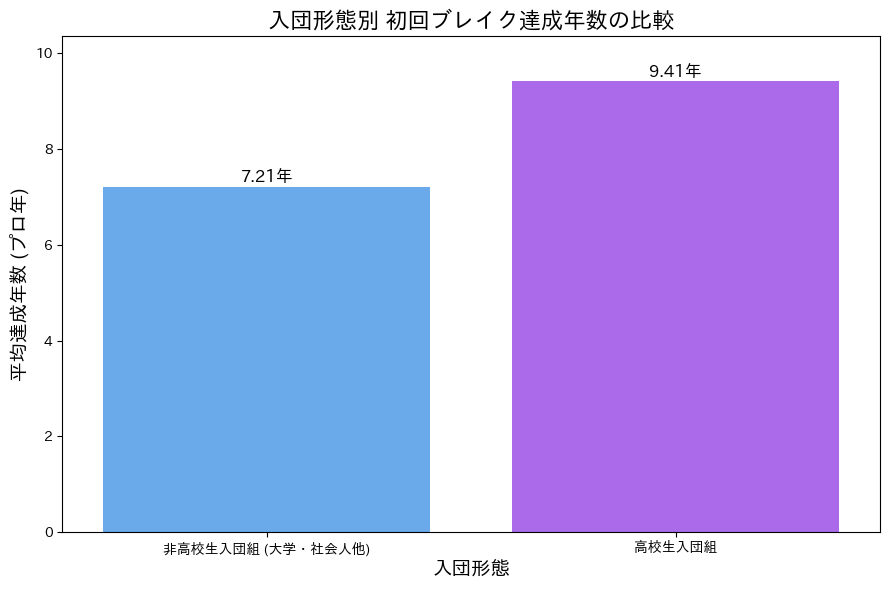

In [8]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

# 日本語表示の設定 (フォントエラー対策済み)
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['axes.unicode_minus'] = False 

# --- ファイルパスの定義（ここをご自身の環境に合わせて変更してください） ---
CSV_PATH_BAT = 'stats_bat.csv' 
CSV_PATH_PLAYERS = 'players.csv'
# ------------------------------------------------------------------

print("1. データの読み込みと処理を開始します...")

# ファイルの存在確認
if not os.path.exists(CSV_PATH_BAT) or not os.path.exists(CSV_PATH_PLAYERS):
    print(f"\n【エラー】指定されたパスにファイルが見つかりません。")
    print("パスが正しいか確認し、ファイルを配置してください。")
    exit()

# データの読み込み（文字コード判別対応）
def load_csv_data(filepath):
    for enc in ['shift_jis', 'cp932', 'utf-8']:
        try:
            df = pd.read_csv(filepath, encoding=enc)
            print(f"  -> {os.path.basename(filepath)} を {enc} で読み込み成功。")
            return df
        except UnicodeDecodeError:
            continue
    raise UnicodeDecodeError(f"すべてのエンコーディングで {os.path.basename(filepath)} の読み込みに失敗しました。")

try:
    stats_bat = load_csv_data(CSV_PATH_BAT)
    players = load_csv_data(CSV_PATH_PLAYERS)
except UnicodeDecodeError as e:
    print(f"\n【重大エラー】{e}")
    exit()

# --- データ加工処理 ---

# 1. 選手データから必要なカラムを抽出 (★college_nameを追加)
required_player_cols = ['player_id', 'draft_year', 'draft_round', 'college_name']
missing_player_cols = [col for col in required_player_cols if col not in players.columns]
if missing_player_cols:
    print(f"\n【エラー】players.csv に必要なカラム ({', '.join(missing_player_cols)}) が見つかりません。")
    print("入団形態の分類をスキップします。")
    exit()

player_meta = players[required_player_cols].drop_duplicates(subset=['player_id'])
player_meta['draft_year'] = pd.to_numeric(player_meta['draft_year'], errors='coerce')
player_meta = player_meta.dropna(subset=['draft_year'])

# 2. 成績データと結合
if 'season_year' not in stats_bat.columns:
    print("\n【エラー】'stats_bat.csv'に成績年度を示す 'season_year' カラムが見つかりません。")
    exit()
    
df = pd.merge(stats_bat, player_meta, on='player_id', how='inner')

# 3. プロ年数の計算
df['pro_year'] = df['season_year'] - df['draft_year']

# 4. フィルタリング (活躍事例: プロ5年目以上, 規定打席, 打率.250以上)
df_active = df[df['pro_year'] >= 5]
df_active = df_active[df_active['pa'] >= 444]
df_active = df_active[df_active['ab'] > 0].copy()
df_active['avg'] = df_active['h'] / df_active['ab']
df_active = df_active[df_active['avg'] >= 0.250]


# --- 初回達成年のみを抽出する処理 (初回ブレイク事例) ---
if len(df_active) > 0:
    first_success_year = df_active.groupby('player_id')['season_year'].min().reset_index()
    first_success_year.rename(columns={'season_year': 'first_success_year'}, inplace=True)
    
    df_active_merged = pd.merge(df_active, first_success_year, on='player_id', how='left')
    df_clean = df_active_merged[
        df_active_merged['season_year'] == df_active_merged['first_success_year']
    ].copy()
else:
    df_clean = pd.DataFrame()


# --- 5. 入団形態の分類と平均達成年数の計算 ---

if len(df_clean) > 0:
    print(f"\n2. 初回ブレイク事例件数: {len(df_clean)} 件")

    # 入団形態の分類: college_nameが空かどうかで判断
    df_clean['entry_type'] = df_clean['college_name'].apply(
        lambda x: '非高校生入団組 (大学・社会人他)' if pd.notna(x) and x != '' else '高校生入団組'
    )
    
    # 形態別にプロ年数の平均を計算
    avg_pro_year = df_clean.groupby('entry_type')['pro_year'].agg(
        ['count', 'mean', 'std']
    ).round(2).sort_values(by='mean')
    
    avg_pro_year.columns = ['事例件数', '平均達成年数', '標準偏差']
    
    print("\n-----------------------------------------------------")
    print("🏆 入団形態別：初回ブレイク達成年数の平均")
    print("（プロ5年目以降で規定打席・打率.250を初めて達成した年）")
    print("-----------------------------------------------------")
    print(avg_pro_year.to_markdown())

    
    # --- グラフ描画 ---
    plt.figure(figsize=(9, 6))
    
    sns.barplot(
        x=avg_pro_year.index, 
        y=avg_pro_year['平均達成年数'], 
        hue=avg_pro_year.index,
        palette="cool", 
        legend=False
    )
    
    # 平均達成年数の値をグラフ上に表示
    for i, row in avg_pro_year.reset_index().iterrows():
        plt.text(
            i, 
            row['平均達成年数'] + 0.1, 
            f"{row['平均達成年数']:.2f}年", 
            ha='center', 
            fontsize=12, 
            weight='bold'
        )

    plt.title('入団形態別 初回ブレイク達成年数の比較', fontsize=16)
    plt.xlabel('入団形態', fontsize=14)
    plt.ylabel('平均達成年数 (プロ年)', fontsize=14)
    plt.ylim(0, avg_pro_year['平均達成年数'].max() * 1.1)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    

else:
    print("\n【最終結果】初回ブレイク事例が0件のため、分析はスキップされました。")